# Setup

```
pip install git+https://github.com/scverse/spatialdata.git@main
pip install git+https://github.com/scverse/spatialdata-io.git@main
```

This is the stuff you have to edit; the rest of the sections can run as-is after you've set the needed parameters.

---

`coord_suffix` must align with 
* the sub-directory (corresponds to region, e.g., "mucosa") under the `dir_coord` directory where the Xenium Explorer-exported selection files are stored, and
* the suffixes of the coordinate selection files (see file naming conventions below).
  
The `AnnData` objects created will have this suffix as well (e.g., `Uninflamed-50452A_mucosa.h5ad`).

---

Selection files should be named by this convention:
`<library_id>_<coord_suffix>.csv`.

For example, if `dir_coord` is `.../coordinates/mucosa`, the mucosa selection file for sample 50452A should be under `.../coordinates/mucosa/50452A_mucosa.csv`. 

More specifically, if the coordinates directory is under `/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates`, and the selection region is "mucosa,"`dir_coord` should be `/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates/mucosa`, and the full file path for this sample would be `/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates/mucosa/50452A_mucosa.csv`.

---

**As with any other file naming schema, suffixes/directory names should not any special characters other than underscores (`_`) (no periods, dashes, spaces, etc.).**

N.B. In the above explanation, `library_id` refers to library/original sample ID without condition (e.g., "50452A", not "Uninflamed-50452A" like in other places). Remember that `coord_suffix` should also be the name of the parent directory of the coordinate file. I include this information in both the directory and file name to prevent mix-ups should files be moved or placed in the wrong folder.

Loading the metadata allows us to find the object IDs (e.g., for TUQ97N, object IDs are in the format <condition (Inflamed/Uninflamed/Stricture)><block_id>) corresponding to the sample IDs.


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import math
import functools
import traceback
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import shapely.validation
from shapely.geometry import box
import anndata
import scanpy as sc
# import spatialdata_plot
import numpy as np
import pandas as pd
import corescpy as cr

# Files & Directories
panel = "TUQ97N"  # Xenium panel ID
direc = "/mnt/cho_lab/bbdata2/"  # mounted NFS with Xenium raw data
obj_dir = os.path.join(  # this path will point to where original .h5ads are
    "/mnt/cho_lab/disk2",  # Spark entry directory
    "elizabeth",  # change if objects in different person's/your folder
    f"data/shared-xenium-library/outputs/{panel}/nebraska")  # subdirectory
out_new = os.path.join("/mnt/cho_lab/disk2", os.getlogin(),  # for new objects
                       f"data/shared-xenium-library/outputs/{panel}/nebraska")
mdf = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/samples_"
          f"{panel}.csv")  # metadata file path (for now; will soon be on NFS)

# Main
write_object = True  # change to True when you're ready to save objects
overwrite = False  # overwrite if already exists?
regions = ["mucosa", "serosa", "myenteric_plexus", "submucosa",
           "smc_circular", "smc_longitudinal"]
col_leiden = "leiden_res1pt5_dist0_npc30"
col_ann = "Bucket"
cells_as_circles = True
allow_make_valid = True  # allow shapely package to correct invalid geometries
libs = [  # sample IDs from patients for whom we have all conditions
    "50452A", "50452B", "50452C",  # old segmentation
    "50006A", "50006B", "50006C",  # rest are new segmentation
    "50217A", "50217B", "50217C",
    "50336B", "50336C", "50336A",
    "50403A2", "50403B", "50403C1"
]  # excludes low-quality sample/condition replicates 50403A1 & 50403C2
# libs = ["50006A", "50006B", "50217A", "50217B", "50336B", "50336C",
#         "50403B", "50403A2"]  # just inflamed/uninflamed (no strictures)
# libs = None  # to run all available samples
input_suffix = ""  # in case want to crop objects with some suffix
# due to creation of a subsidiary object, e.g., for
# "Stricture-50452C_downsampled.h5ad"
# input_suffix would be "_downsampled". For "main" objects, input_suffix=""
plot = True  # could slow process down if large samples/cropped area

#  Your Folders
constants_dict = cr.get_panel_constants(panel_id=panel)

# Constants (Shouldn't Need Edits Unless Extreme Process Changes)
cso, col_sample, col_condition, col_inflamed, col_subject = [
    constants_dict[x] if x in constants_dict else None for x in [
        "col_sample_id_o", "col_sample_id", "col_condition",
        "col_inflamed", "col_subject"]]
dir_data = os.path.join(direc, f"outputs/{panel}")
files = functools.reduce(lambda i, j: i + j, [[os.path.join(
    run, i) for i in os.listdir(os.path.join(
        dir_data, run))] for run in os.listdir(dir_data)])  # all data paths
os.makedirs(obj_dir, exist_ok=True)  # make output directory if needed
metadata = cr.pp.get_metadata_cho(direc, mdf, panel_id=panel, samples=libs)
metadata[col_subject]

# Subset Data by Coordinate Files & Write Cropped Objects

Subset the data by coordinates (`corescpy` can use Xenium Explorer-exported manual selection files to get those coordinates) and then write the cropped objects to `obj_dir/<coord_suffix>`.

In [3]:
for s in libs:  # iterate samples
    print(f"\n\n{'=' * 80}\n{s}\n{'=' * 80}\n\n")
    fff = os.path.join(dir_data, np.array(files)[np.where([
        s == os.path.basename(x).split("__")[2].split("-")[0]
        for x in files])[0][0]])  # sample's Xenium data directory path
    lib = metadata.reset_index().set_index(cso).loc[s][col_sample]
    file_obj_proc = os.path.join(obj_dir, f"{lib}{input_suffix}.h5ad")
    if overwrite is False:  # skip entirely if all crops exist & no overwrite
        all_files = [os.path.join(out_new, "objects_cropped",
                                  r, f'{lib}_{r}.h5ad') for r in regions]
        if overwrite is False and all([os.path.exists(r) for r in all_files]):
            print(f"*** All subsets {', '.join(all_files)} already exist")
            continue
    self = cr.Spatial(fff, library_id=lib,
                      cells_as_circles=cells_as_circles)  # load original data
    adata = sc.read_h5ad(file_obj_proc)  # processed adata



Counts: Initial: table


	Observations: 1038830

	Genes: 469







 AnnData object with n_obs × n_vars = 1038830 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts' 

                      gene_ids    feature_types   genome
gene_symbols                                           
ABCA7         ENSG00000064687  Gene Expression  Unknown
ACTA2         ENSG00000107796  Gene Expression  Unknown
ACTG2         ENSG00000163017  Gene Expression  Unknown
ADAM15        ENSG00000143537  Gene Expression  Unknown
ADAM28        ENSG00000042980  Gene Expression  Unknown 

 



col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="Samp



		****************************************
		smc_longitudinal
		****************************************




Data: /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-008/output-XETG00189__0015521__50217A-TUQ97N-EA__20240415__212906
Object: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Inflamed-50217A.h5ad
Coordinates: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates/smc_longitudinal/50217A_smc_longitudinal.csv
Ouput: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/smc_longitudinal/Inflamed-50217A_smc_longitudinal.h5ad


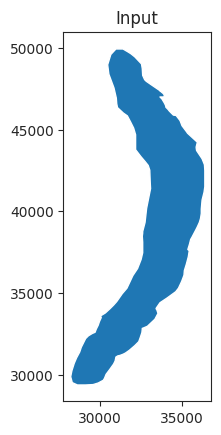

In [5]:
        coord_suffix = "smc_longitudinal"
        sdata = None
        print(f"\n\n\t\t{'*' * 40}\n\t\t{coord_suffix}\n\t\t{'*' * 40}\n\n")
        dir_coord = os.path.join(
            out_new, "coordinates", coord_suffix)  # coordinates (NFS soon?)
        out = os.path.join(out_new, "objects_cropped", coord_suffix)  # path
        os.makedirs(out, exist_ok=True)  # make sub-directory for new objects?
        file_coord = os.path.join(dir_coord, s + f"_{coord_suffix}.csv")
        file_obj_crop = os.path.join(out, f"{lib}_{coord_suffix}.h5ad")
        print(f"\n\nData: {fff}\nObject: {file_obj_proc}"
              f"\nCoordinates: {file_coord}\nOuput: {file_obj_crop}")
        # try:
        sdata = self.crop(
            file_coord, allow_make_valid=allow_make_valid)  # crop
        i_x = sdata.table.obs["cell_id"].copy()
        # orig = sdata.table.copy()
        del sdata.table
        sdata.table = adata[adata.obs["cell_id"].isin(i_x[
            i_x.isin(adata.obs["cell_id"])])]  # coordinate- & pp-filtered

In [ ]:
for s in libs:  # iterate samples
    print(f"\n\n{'=' * 80}\n{s}\n{'=' * 80}\n\n")
    fff = os.path.join(dir_data, np.array(files)[np.where([
        s == os.path.basename(x).split("__")[2].split("-")[0]
        for x in files])[0][0]])  # sample's Xenium data directory path
    lib = metadata.reset_index().set_index(cso).loc[s][col_sample]
    file_obj_proc = os.path.join(obj_dir, f"{lib}{input_suffix}.h5ad")
    if overwrite is False:  # skip entirely if all crops exist & no overwrite
        all_files = [os.path.join(out_new, "objects_cropped",
                                  r, f'{lib}_{r}.h5ad') for r in regions]
        if overwrite is False and all([os.path.exists(r) for r in all_files]):
            print(f"*** All subsets {', '.join(all_files)} already exist")
            continue
    self = cr.Spatial(fff, library_id=lib,
                      cells_as_circles=cells_as_circles)  # load original data
    adata = sc.read_h5ad(file_obj_proc)  # processed adata
    # self.update_from_h5ad(file_obj_proc)  # update with processed object
    for coord_suffix in regions:
        sdata = None
        print(f"\n\n\t\t{'*' * 40}\n\t\t{coord_suffix}\n\t\t{'*' * 40}\n\n")
        dir_coord = os.path.join(
            out_new, "coordinates", coord_suffix)  # coordinates (NFS soon?)
        out = os.path.join(out_new, "objects_cropped", coord_suffix)  # path
        os.makedirs(out, exist_ok=True)  # make sub-directory for new objects?
        file_coord = os.path.join(dir_coord, s + f"_{coord_suffix}.csv")
        file_obj_crop = os.path.join(out, f"{lib}_{coord_suffix}.h5ad")
        if overwrite is False and os.path.exists(file_obj_crop):
            print(f"*** Subset {file_obj_crop} already exists")
            continue
        if not os.path.exists(file_coord):
            print(f"*** Coordinate file {file_coord} doesn't exist")
            continue
        print(f"\n\nData: {fff}\nObject: {file_obj_proc}"
              f"\nCoordinates: {file_coord}\nOuput: {file_obj_crop}")
        # try:
        sdata = self.crop(
            file_coord, allow_make_valid=allow_make_valid)  # crop
        i_x = sdata.table.obs["cell_id"].copy()
        # orig = sdata.table.copy()
        del sdata.table
        sdata.table = adata[adata.obs["cell_id"].isin(i_x[
            i_x.isin(adata.obs["cell_id"])])]  # coordinate- & pp-filtered
        if plot:
            try:
                sdata.pl.render_labels("cell_labels").pl.show()  # plot
            except Exception:
                pass
        if write_object is True:
            sdata.table.write_h5ad(file_obj_crop)  # write cropped
        # except Exception:
        #     print(traceback.format_exc(),
        #           f"Cropping \n\n{s}, {coord_suffix} failed!")
print("\n\nCompleted!")

In [ ]:
dff = gpd.GeoDataFrame(geometry=coords)
dff["geometries"] = dff.apply(lambda x: [g for g in x.geometry.geoms], axis=1)
dff = dff.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")
dff

In [ ]:
kws = {"target_coordinate_system": "global", "filter_table": True}
coords = cr.pp.xenium_explorer_selection(file_coord)
print(type(coords))
p_coords = gpd.GeoSeries(coords).plot()
p_coords.set_title("Input")
plt.show()
coords = shapely.validation.make_valid(coords)
print(type(coords))
p_coords_new = gpd.GeoSeries(coords).plot()

In [ ]:
coord_suffix

In [ ]:
data = {}
for i, p in enumerate(coords.geoms):  # Handle each Polygon in MultiPolygon
    data[f"Selection { + 1i}"] = []
    for xi, yi in zip(*p.exterior.xy):
        data[f"Selection { + 1i}"] += [{"X": xi * p_size, "Y": yi * p_size}]
    data[f"Selection {i + 1}"] = pd.DataFrame(data[f"Selection { + 1i}"])
data = pd.concat(data, names=["Selection"]).reset_index(1, drop=True)
cols = [f"", ", ".join(data.reset_index().Selection.unique())]
data = pd.concat([pd.DataFrame([["", ""]], index=[
    "Areas (µm^2): x"], columns=cols), pd.DataFrame(data.columns, columns=[
        "Selection"], index=cols).T, pd.DataFrame(np.array(
            data), index=data.index, columns=cols)]).rename_axis(
                "#Selection name: ")  # Xenium format
# data.to_csv(os.path.join(out_new, "coordinates", "mucosa",
#                          "50217A_mucosa.csv"))

In [ ]:
sdata_crop = self.adata.query.polygon(coords, **kws)

In [ ]:
import squidpy as sq

sq.pl.spatial_scatter(
    sdata_crop.table, library_id="spatial", shape=None,
    color=None, wspace=0.4, legend_loc=None)

In [ ]:
i_x = sdata_crop.table.obs["cell_id"]
ann = adata[adata.obs["cell_id"].isin(i_x[
                i_x.isin(adata.obs["cell_id"])])]  # coordinate- & pp-filtered

In [ ]:
sq.pl.spatial_scatter(
    ann, library_id="spatial", shape=None,
    color="bucket_res1pt5_dist0_npc30", wspace=0.4)

In [ ]:
ann.write_h5ad(file_obj_crop)

In [ ]:
ann.obs["bucket_res1pt5_dist0_npc30"].value_counts()

In [ ]:
        coord_suffix = "submucosa"
        dir_coord = os.path.join(
            out_new, "coordinates", coord_suffix)  # coordinates (NFS soon?)
        out = os.path.join(out_new, "objects_cropped", coord_suffix)  # path
        os.makedirs(out, exist_ok=True)  # make sub-directory for new objects?
        file_coord = os.path.join(dir_coord, s + f"_{coord_suffix}.csv")
        file_obj_crop = os.path.join(out, f"{lib}_{coord_suffix}.h5ad")

In [ ]:
                    coords = cr.pp.xenium_explorer_selection(file_coord)
                    print(coords.is_valid)
                    coords = shapely.validation.make_valid(coords)
                    coords

In [ ]:
spatialdata.SpatialData.get_annotated_regions(sdata_crop.table)

In [ ]:
sdata_crop.shapes["cell_circles"].index

In [ ]:
sdata_crop.tables

In [ ]:
sdata.tables

In [ ]:
sdata = self.adata.query.polygon(coords, **kws)

In [ ]:
sdata.labels["cell_labels"]

In [ ]:
coords

In [ ]:
sdata.shapes["cell_circles"]

In [ ]:
# sdata.tables["table"].write_h5ad(file_obj_crop)  # write cropped

# Example Setting Regions by Exclusion

In [ ]:
olm = cr.pp.xenium_explorer_selection(os.path.join(
    out_new, "coordinates", "smc_longitudinal",
    f"{s_o}_smc_longitudinal.csv"))

In [ ]:
whole_valid = shapely.validation.make_valid(whole)

In [ ]:
whole_valid

In [ ]:
leftover = shapely.validation.make_valid(whole_valid.difference(muc))
for x in [mye, icm, olm, ser]:
    leftover = shapely.validation.make_valid(whole_valid.difference(x))
leftover

In [ ]:
# whole = shapely.Polygon(list(self.adata.shapes["cell_circles"].geometry))

In [ ]:
s_o = "50217A"
out_new = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/"
              "outputs/TUQ97N/nebraska")
# mid = pd.read_csv(os.path.join(out_new, f"coordinates/{s_o}_mid.csv"),
#                   index_col=0).iloc[:, 0]
# mid = gpd.GeoDataFrame(mid, geometry=gpd.GeoSeries.from_wkt(
#     mid), crs="EPSG:4326")
# mid = mid.geometry.apply(lambda geom: shapely.Polygon(geom)).iloc[0]
mye, ser, muc, icm = [cr.pp.xenium_explorer_selection(os.path.join(
    out_new, "coordinates", r, f"{s_o}_{r}.csv"))
            for r in ["myenteric_plexus", "serosa", "mucosa", "smc_circular"]]
mye, ser, muc, icm = [x if x.is_valid else shapely.validation.make_valid(
    x) for x in [mye, ser, muc, icm]]
# muc = cr.pp.xenium_explorer_selection(os.path.join(
#     out_new, "coordinates", "mucosa", f"{s_o}_mucosa_full.csv"))
# muc = shapely.validation.make_valid(muc)
# other = shapely.validation.make_valid(cr.pp.xenium_explorer_selection(
#     os.path.join(out_new, "coordinates/50217A_other.csv")))
# smc = shapely.validation.make_valid(cr.pp.xenium_explorer_selection(
#     os.path.join(out_new, "coordinates/50217A_smc.csv")))
# whole = shapely.validation.make_valid(cr.pp.xenium_explorer_selection(
#     os.path.join(out_new, "coordinates/50217A_all.csv")))
# olm = cr.pp.xenium_explorer_selection(os.path.join(
#     out_new, "coordinates", "smc_longitudinal",
#     f"{s_o}_smc_longitudinal.csv"))
other, olm, smc, whole = None, None, None, None

In [ ]:
for r in zip(["whole", "mye", "ser", "muc", "smc", "icm", "olm"], [
        whole, mye, ser, muc, smc, icm, olm]):
    if r[1] is None:
        continue
    p_coords = gpd.GeoSeries(r[1]).plot()
    p_coords.set_title(r[0])
    plt.show()

In [ ]:
olm = smc.difference(mye).difference(icm).difference(ser)
olm

In [ ]:
sub = whole.difference(muc).difference(icm).difference(olm).difference(
    mye).difference(ser).difference(smc)
sub

In [ ]:
coords.boundary.xy[0][1]

In [ ]:
pd.DataFrame([[j / 100 for j in i] for i in coords.boundary.xy], index=["X", "Y"]).T

In [ ]:
shapely.Polygon(pd.DataFrame([[j / 10 for j in i] for i in coords.boundary.xy], index=["X", "Y"]).T.values / 0.2125)

In [ ]:
self.rna.obsm["spatial"]

In [ ]:
coords

In [ ]:
kws = {"target_coordinate_system": "global",
        "filter_table": True}

sdata_crop = self.adata.query.polygon(shapely.Polygon(pd.DataFrame([[j / 100 for j in i] for i in coords.boundary.xy], index=["X", "Y"]).T.values), **kws)
sdata_crop

In [ ]:
i_x = sdata.table.obs["cell_id"].copy()
orig = sdata.table.copy()
del sdata.table
sdata.table = adata[adata.obs["cell_id"].isin(i_x[
    i_x.isin(list(adata.obs["cell_id"]))])]  # coordinate- & pp-filtered
if plot:
    try:
        sdata.pl.render_labels("cell_labels").pl.show()  # plot
    except Exception:
        pass
if write_object is True:
    sdata.table.write_h5ad(file_obj_crop)  # write cropped

In [ ]:
p_size = 0.2125  # pixel size

data = {}
for i, p in enumerate(olm.geoms):  # Handle each Polygon in MultiPolygon
    data[f"Selection {i + 1}"] = []
    for xi, yi in zip(*p.exterior.xy):
        data[f"Selection {i + 1}"] += [{"X": xi * p_size, "Y": yi * p_size}]
    data[f"Selection {i + 1}"] = pd.DataFrame(data[f"Selection {i + 1}"])
data = pd.concat(data, names=["Selection"]).reset_index(1, drop=True)
cols = [f"", ", ".join(data.reset_index().Selection.unique())]
data = pd.concat([pd.DataFrame([["", ""]], index=[
    "Areas (µm^2): x"], columns=cols), pd.DataFrame(data.columns, columns=[
        "Selection"], index=cols).T, pd.DataFrame(np.array(
            data), index=data.index, columns=cols)]).rename_axis(
                "#Selection name: ")  # Xenium format
# os.system("mv " + os.path.join(
#     out_new, "coordinates", "smc_longitudinal",
#     "50217A_smc_longitudinal.csv") + " " + os.path.join(
#         out_new, "coordinates", "smc_longitudinal",
#         "50217A_smc_longitudinal_old.csv"))
# data.to_csv(os.path.join(out_new, "coordinates", "smc_longitudinal",
#                          "50217A_smc_longitudinal.csv"))

data = {}
for i, p in enumerate(muc.geoms):  # Handle each Polygon in MultiPolygon
    data[f"Selection {i + 1}"] = []
    for xi, yi in zip(*p.exterior.xy):
        data[f"Selection {i + 1}"] += [{"X": xi * p_size, "Y": yi * p_size}]
    data[f"Selection {i + 1}"] = pd.DataFrame(data[f"Selection {i + 1}"])
data = pd.concat(data, names=["Selection"]).reset_index(1, drop=True)
cols = [f"", ", ".join(data.reset_index().Selection.unique())]
data = pd.concat([pd.DataFrame([["", ""]], index=[
    "Areas (µm^2): x"], columns=cols), pd.DataFrame(data.columns, columns=[
        "Selection"], index=cols).T, pd.DataFrame(np.array(
            data), index=data.index, columns=cols)]).rename_axis(
                "#Selection name: ")  # Xenium format
# os.system("mv " + os.path.join(
#     out_new, "coordinates", "mucosa",
#     "50217A_mucosa.csv") + " " + os.path.join(
#         out_new, "coordinates", "mucosa", "50217A_mucosa_old.csv"))
# data.to_csv(os.path.join(out_new, "coordinates", "mucosa",
#                          "50217A_mucosa.csv"))

data = {}
for i, p in enumerate(icm.geoms):  # Handle each Polygon in MultiPolygon
    data[f"Selection {i + 1}"] = []
    for xi, yi in zip(*p.exterior.xy):
        data[f"Selection {i + 1}"] += [{"X": xi * p_size, "Y": yi * p_size}]
    data[f"Selection {i + 1}"] = pd.DataFrame(data[f"Selection {i + 1}"])
data = pd.concat(data, names=["Selection"]).reset_index(1, drop=True)
cols = [f"", ", ".join(data.reset_index().Selection.unique())]
data = pd.concat([pd.DataFrame([["", ""]], index=[
    "Areas (µm^2): x"], columns=cols), pd.DataFrame(data.columns, columns=[
        "Selection"], index=cols).T, pd.DataFrame(np.array(
            data), index=data.index, columns=cols)]).rename_axis(
                "#Selection name: ")  # Xenium format
# os.system("mv " + os.path.join(
#     out_new, "coordinates", "smc_circular",
#     "50217A_smc_circular.csv") + " " + os.path.join(
#         out_new, "coordinates", "smc_circular",
#         "50217A_smc_circular_old.csv"))
# data.to_csv(os.path.join(out_new, "coordinates", "smc_circular",
#                          "50217A_smc_circular.csv"))

data = {}
for i, p in enumerate(sub.geoms):  # Handle each Polygon in MultiPolygon
    data[f"Selection {i + 1}"] = []
    for xi, yi in zip(*p.exterior.xy):
        data[f"Selection {i + 1}"] += [{"X": xi * p_size, "Y": yi * p_size}]
    data[f"Selection {i + 1}"] = pd.DataFrame(data[f"Selection {i + 1}"])
data = pd.concat(data, names=["Selection"]).reset_index(1, drop=True)
cols = [f"", ", ".join(data.reset_index().Selection.unique())]
data = pd.concat([pd.DataFrame([["", ""]], index=[
    "Areas (µm^2): x"], columns=cols), pd.DataFrame(data.columns, columns=[
        "Selection"], index=cols).T, pd.DataFrame(np.array(
            data), index=data.index, columns=cols)]).rename_axis(
                "#Selection name: ")  # Xenium format
# os.system("mv " + os.path.join(
#     out_new, "coordinates", "submucosa",
#     "50217A_submucosa.csv") + " " + os.path.join(
#         out_new, "coordinates", "submucosa",
#         "50217A_submucosa_old.csv"))
# data.to_csv(os.path.join(out_new, "coordinates", "submucosa",
#                          "50217A_submucosa.csv"))


# Example if Not MultiPolygon
# data = {}
# for i, p in enumerate(coords.boundary.geoms)
#     data[f"Selection {i + 1}"] = []
#     for xi, yi in zip(*p.xy):
#         data[f"Selection {i + 1}"] += [{"X": xi * p_size, "Y": yi * p_size}]
#     data[f"Selection {i + 1}"] = pd.DataFrame(data[f"Selection {i + 1}"])
# data = pd.concat(data, names=["Selection"]).reset_index(1, drop=True)
# cols = [f"", ", ".join(data.reset_index().Selection.unique())]
# data = pd.concat([pd.DataFrame([["", ""]], index=[
#     "Areas (µm^2): x"], columns=cols), pd.DataFrame(data.columns, columns=[
#         "Selection"], index=cols).T, pd.DataFrame(np.array(
#             data), index=data.index, columns=cols)]).rename_axis(
#                 "#Selection name: ")  # Xenium format

# Or
# data = pd.DataFrame(coords.boundary.xy, index=["X", "Y"]).T.assign(
#     Selection="Selection 1").set_index("Selection")
# cols = [f"", ", ".join(data.reset_index().Selection.unique())]
# data = pd.concat([pd.DataFrame([["", ""]], index=[
#     "Areas (µm^2): x"], columns=cols), pd.DataFrame(data.columns, columns=[
#         "Selection"], index=cols).T, pd.DataFrame(np.array(
#             data), index=data.index, columns=cols)]).rename_axis(
#                 "#Selection name: ")  # Xenium format

In [ ]:
for r in zip(["whole", "mye", "ser", "muc", "smc", "icm", "olm"], [
        whole, mye, ser, muc, smc, icm, olm]):
    if r[1] is None:
        continue
    p_coords = gpd.GeoSeries(r[1]).plot()
    p_coords.set_title(r[0])
    plt.show()

In [9]:
coord_suffix="submucosa"



Data: /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-008/output-XETG00189__0015521__50217A-TUQ97N-EA__20240415__212906
Object: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Inflamed-50217A.h5ad
Coordinates: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates/submucosa/50217A_submucosa.csv
Ouput: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/submucosa/Inflamed-50217A_submucosa.h5ad


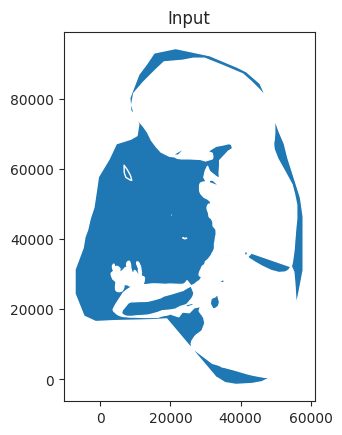

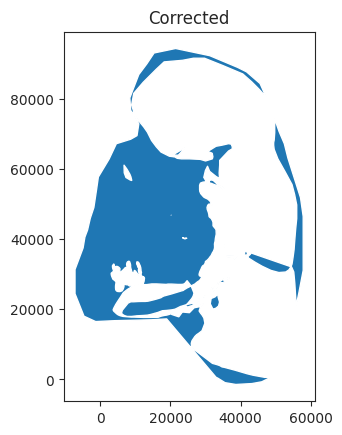

View of AnnData object with n_obs × n_vars = 244586 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'sample_id', 'subject_id', 'run_id', 'panel_id', 'slide_id', 'clinical_block', 'description', 'date_hybridization', 'date_sectioned', 'location', 'inflammation', 'stricture', 'Condition', 'Age', 'Annotation', 'CDKN1A_PLAUR_threshold2', 'CDKN1A_TP53_PLAUR_threshold2', 'CDKN1A_TP53_threshold2', 'CDKN1A_threshold2', 'Diagnosis', 'Disease_Status', 'Hispanic', 'IL7R_KLRB1_RORC_threshold2', 'IL7R_KLRB1_threshold2', 'IL7R_RORC_threshold2', 'IL7R_threshold2', 'KLRB1_RORC_threshold2', 'KLRB1_threshold2', 'PLAUR_threshold2', 'RORC_threshold2', 'Race', 'Sex', 'TP53_PLAUR_threshold2', 'TP53_threshold2', 'annotation_res0pt5_dist0pt5_npc30', 'annotation_res0pt75_dist0pt3_npc30', 'annotation_res1pt5_dist0_npc30', 'assay_protein', 

In [10]:
        # s = "50217A"

        # fff = os.path.join(dir_data, np.array(files)[np.where([
        #     s == os.path.basename(x).split("__")[2].split("-")[0]
        #     for x in files])[0][0]])  # sample's Xenium data directory path
        # lib = metadata.reset_index().set_index(cso).loc[s][col_sample]
        # file_obj_proc = os.path.join(obj_dir, f"{lib}{input_suffix}.h5ad")
        # self = cr.Spatial(fff, library_id=lib,
        #                 cells_as_circles=cells_as_circles)  # load original data
        # adata = sc.read_h5ad(file_obj_proc)  # processed adata
        # print(f"\n\n\t\t{'*' * 40}\n\t\t{s}\n\t\t{'*' * 40}\n\n")
        dir_coord = os.path.join(
            out_new, "coordinates", coord_suffix)  # coordinates (NFS soon?)
        out = os.path.join(out_new, "objects_cropped", coord_suffix)  # path
        os.makedirs(out, exist_ok=True)  # make sub-directory for new objects?
        file_coord = os.path.join(dir_coord, s + f"_{coord_suffix}.csv")
        file_obj_crop = os.path.join(out, f"{lib}_{coord_suffix}.h5ad")
        print(f"\n\nData: {fff}\nObject: {file_obj_proc}"
              f"\nCoordinates: {file_coord}\nOuput: {file_obj_crop}")
        sdata = self.crop(
            file_coord, allow_make_valid=allow_make_valid)  # crop
        i_x = sdata.table.obs["cell_id"].copy()
        del sdata.table
        sdata.table = adata[adata.obs["cell_id"].isin(i_x[
            i_x.isin(adata.obs["cell_id"])])]  # coordinate- & pp-filtered
        sdata.table

In [11]:
file_obj_crop

'/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/submucosa/Inflamed-50217A_submucosa.h5ad'



Data: /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-008/output-XETG00189__0015521__50217A-TUQ97N-EA__20240415__212906
Object: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Inflamed-50217A.h5ad
Coordinates: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates/smc_longitudinal/50217A_smc_longitudinal.csv
Ouput: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/smc_longitudinal/Inflamed-50217A_smc_longitudinal.h5ad


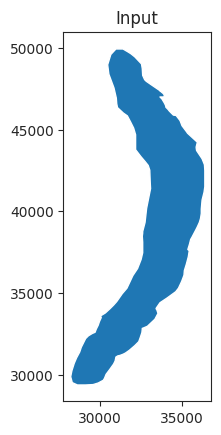

In [6]:
        # s = "50217A"

        # fff = os.path.join(dir_data, np.array(files)[np.where([
        #     s == os.path.basename(x).split("__")[2].split("-")[0]
        #     for x in files])[0][0]])  # sample's Xenium data directory path
        # lib = metadata.reset_index().set_index(cso).loc[s][col_sample]
        # file_obj_proc = os.path.join(obj_dir, f"{lib}{input_suffix}.h5ad")
        # self = cr.Spatial(fff, library_id=lib,
        #                 cells_as_circles=cells_as_circles)  # load original data
        # adata = sc.read_h5ad(file_obj_proc)  # processed adata
        # print(f"\n\n\t\t{'*' * 40}\n\t\t{s}\n\t\t{'*' * 40}\n\n")
        dir_coord = os.path.join(
            out_new, "coordinates", coord_suffix)  # coordinates (NFS soon?)
        out = os.path.join(out_new, "objects_cropped", coord_suffix)  # path
        os.makedirs(out, exist_ok=True)  # make sub-directory for new objects?
        file_coord = os.path.join(dir_coord, s + f"_{coord_suffix}.csv")
        file_obj_crop = os.path.join(out, f"{lib}_{coord_suffix}.h5ad")
        print(f"\n\nData: {fff}\nObject: {file_obj_proc}"
              f"\nCoordinates: {file_coord}\nOuput: {file_obj_crop}")
        sdata = self.crop(
            file_coord, allow_make_valid=allow_make_valid)  # crop
        i_x = sdata.table.obs["cell_id"].copy()
        del sdata.table
        sdata.table = adata[adata.obs["cell_id"].isin(i_x[
            i_x.isin(adata.obs["cell_id"])])]  # coordinate- & pp-filtered

In [8]:
sdata.table.write_h5ad("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/smc_longitudinal/Inflamed-50217A_smc_longitudinal.h5ad")

In [ ]:
poly_right

In [ ]:
sdata_right = self.adata.query.polygon(poly_right, **kws)

In [ ]:
# kws = {"target_coordinate_system": "global", "filter_table": True}
# dff = pd.read_csv(file_coord, skiprows=2)
# poly = dff.groupby("Selection").apply(lambda x: shapely.Polygon(
#     x.drop("Selection", axis=1).values / 0.2125))
# poly_right = poly.iloc[4]
# poly_left = shapely.MultiPolygon(list(poly.drop(poly.index.values[4])))
sdata_left = self.adata.query.polygon(poly_left, **kws)
sdata_right = self.adata.query.polygon(poly_right, **kws)

In [ ]:
left, right = sdata_left.table.copy(), sdata_right.table.copy()

In [ ]:
sdata = spatialdata.concatenate([sdata_left, sdata_right],
                                concatenate_tables=True)

# Workspace

In [ ]:
self.adata.shapes["cell_circles"]["radius"].isna().sum()

In [ ]:
self.rna[self.rna.obs["cell_id"].isin(sdata.shapes["cell_boundaries"].index)]

In [ ]:
self.adata.get_annotated_regions(self.adata.table)

In [ ]:
from spatialdata_io._constants._constants import XeniumKeys

transform = Scale([1.0 / 0.2125, 1.0 / 0.2125], axes=("x", "y"))
radii = np.sqrt(self.rna.obs[XeniumKeys.CELL_NUCLEUS_AREA].to_numpy() / np.pi)

In [ ]:
self.rna.obs[XeniumKeys.CELL_NUCLEUS_AREA]

In [ ]:
[i[1] for i in self.adata._gen_elements()]

In [ ]:
found_regions = set(table.obs["cell_id"].unique().tolist())
target_element_set = ["cell_boundaries"]
symmetric_difference = found_regions.symmetric_difference(target_element_set)
len(symmetric_difference)

In [ ]:
self.adata._change_table_annotation_target(self.adata.table, "cell_labels")

In [ ]:
table.uns.get("spatialdata_attrs")

In [ ]:
self.adata.set_table_annotates_spatialelement("table", region="cell_labels")

In [ ]:
# element = self.adata.shapes["cell_circles"]
# buffered_df = element.copy()
# buffered = to_polygons(element)

In [ ]:
# coord_suffix = "myenteric_plexus"
# coord_suffix = "smc_circular"
coord_suffix = "smc_longitudinal"
# s = "50006B"
# s =  "50217A"
# s = "50217B"

# for s in ["50006A", "50217A", "50403B"]:
for s in ["50006A"]:
    fff = os.path.join(dir_data, np.array(files)[np.where([
        s == os.path.basename(x).split("__")[2].split("-")[0]
        for x in files])[0][0]])  # sample's Xenium data directory path
    lib = metadata.reset_index().set_index(cso).loc[s][col_sample]
    file_obj_proc = os.path.join(obj_dir, f"{lib}{input_suffix}.h5ad")
    dir_coord = os.path.join(
        out_new, "coordinates", coord_suffix)  # coordinates (NFS soon?)
    out = os.path.join(out_new, "objects_cropped", coord_suffix)  # path
    os.makedirs(out, exist_ok=True)  # make sub-directory for new objects?
    file_coord = os.path.join(dir_coord, s + f"_{coord_suffix}.csv")
    file_obj_crop = os.path.join(out, f"{lib}_{coord_suffix}.h5ad")
    if os.path.exists(file_obj_crop):
        continue
    self = cr.Spatial(fff, library_id=lib,
                      cells_as_circles=cells_as_circles)  # load original data
    adata = sc.read_h5ad(file_obj_proc)  # processed adata
    # coords = cr.pp.xenium_explorer_selection(file_coord, pixel_size=0.2125)
    # if isinstance(coords, list):  # if multiple selections...
    #     coords = shapely.MultiPolygon(coords)  # ...union of areas
    # kws = {"target_coordinate_system": "global", "filter_table": True}
    # try:
    #     sdata = self.adata.query.polygon(coords, **kws)  # crop
    # except Exception as err:
    #     if allow_make_valid:
    #         warn("\n\n*** Invalid geometry! Making geometry valid."
    #              "Check new coordinates!\n\n")
    #         coords_new = shapely.validation.make_valid(coords)
    #         sdata = self.adata.query.polygon(coords_new, **kws)  # crop
    #     else:
    #         raise err
    # i_x = sdata.table.obs["cell_id"].copy()
    # del sdata.table
    # sdata.table = adata[adata.obs["cell_id"].isin(i_x[
    #     i_x.isin(adata.obs["cell_id"])])]
    sdata = self.crop(file_coord, allow_make_valid=allow_make_valid)
    if not os.path.exists(file_obj_crop):
        sdata.tables["table"].write_h5ad(os.path.join(
            out, f"{self._library_id}_{coord_suffix}.h5ad"))

In [ ]:
import geopandas as gpd
import shapely

#Create a test dataframe
    #The first line is valid, the second is not, it starts and ends at the same point
wkts  = ["LINESTRING (30 10, 10 30, 40 40)", "LINESTRING (30 10, 30 10)"]
geometries = [shapely.wkt.loads(x) for x in wkts] #Create shapely geometries
df = gpd.GeoDataFrame(geometry=geometries) #And a data frame

invalid = df.loc[~df.geometry.is_valid]

In [ ]:
from shapely.validation import make_valid

In [ ]:
import squidpy as sq

sq.pl.spatial_scatter(sdata_crop.table)

In [ ]:
sdata.pl.render_labels("cell_labels").pl.show()  # plot

In [ ]:
elements = self.gen_spatial_elements()

In [ ]:
cr.pp.xenium_explorer_selection(file_coord)